# LIME 적용하기


## 데이터 import / summary

In [1]:
import os # 위에껄로 대체가능
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
from tensorflow import keras

In [5]:
import pandas as pd
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray # sklearn-image

In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

ImportError: cannot import name 'get_config'

# LIME FOR AV DATA

## Resnet 모델 불러오기

In [ ]:
model_path='save_models'
model_file='av11_ResNet44v1_model.179.h5'

In [ ]:
model=keras.models.load_model(os.path.join(model_path, model_file))

In [ ]:
model.summary()

### Label 확인하기

In [14]:
# train_ds, test_ds=get_dataset()

# train_ds.class_names

Found 90000 files belonging to 9 classes.
Found 27000 files belonging to 9 classes.


In [ ]:
class_names = ['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

#### 아마 위의 순서대로 라벨이 붙을 것.

tf.Tensor(7, shape=(), dtype=int32)
rider
tf.Tensor(3, shape=(), dtype=int32)
motorcycle
tf.Tensor(3, shape=(), dtype=int32)
motorcycle
tf.Tensor(6, shape=(), dtype=int32)
pedestrian
tf.Tensor(1, shape=(), dtype=int32)
bus
tf.Tensor(6, shape=(), dtype=int32)
pedestrian
tf.Tensor(1, shape=(), dtype=int32)
bus
tf.Tensor(0, shape=(), dtype=int32)
bicycle
tf.Tensor(0, shape=(), dtype=int32)
bicycle
tf.Tensor(6, shape=(), dtype=int32)
pedestrian


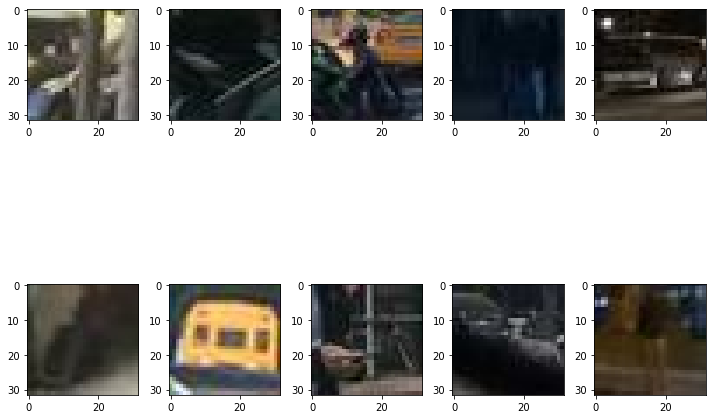

In [18]:
ex_image_list=[]
fig = plt.figure(figsize=(10,15))
        
for idx, (images, labels) in enumerate(train_ds):
    if idx >=10:
        break
    else:
        print(labels[0])
        print(class_names[labels[0].numpy()])
        fig.add_subplot(2,5,idx+1)
        plt.axis=('off')
        plt.imshow(images[0].numpy().astype('float32')/255.0)
    plt.tight_layout()

### Label 순서대로 다 잘 되어 있음. 원핫인코딩도 아마 잘 될 것.  
--> 예측을 제대로 못하는 건 모델이 후반부에 이상해졌을 가능성

### (훈련 전) training set의 라벨 확인

In [60]:
# numpy_iter=list(test_ds.as_numpy_iterator())

In [70]:
print(numpy_iter[0][1])

[1 1 5 4 8 0 8 8 7 4 2 6 7 7 4 5 7 8 1 5 5 5 6 7 7 6 2 8 0 6 3 6 7 4 8 7 5
 3 3 3 1 6 8 3 3 5 7 4 3 2 0 3 4 2 7 1 5 8 0 8 2 0 3 6 3 0 1 3 6 2 6 1 8 1
 8 2 5 3 4 2 0 1 7 0 1 2 6 8 6 2 2 3 6 6 5 4 0 2 7 5 2 2 0 3 1 2 6 4 1 5 1
 3 4 2 1 5 6 8 7 6 5 5 2 0 5 1 5 7]


In [72]:
# x_train, y_train, x_test, y_test=batch_to_numpy(train_ds, test_ds)

> load

In [8]:
x_train=np.load('x_train.npy')
x_test=np.load('x_test.npy')
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')

### 이 때, 데이터의 scale 변한다.

In [9]:
subtract_pixel_mean = True
num_classes=9


# input image dimensions.
input_shape = x_train.shape[1:]
print('input_shape : ', input_shape)
# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train=y_train.astype('uint8')
y_test=y_test.astype('uint8')
# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

input_shape :  (32, 32, 3)
x_train shape: (90000, 32, 32, 3)
90000 train samples
27000 test samples
y_train shape: (90000, 1)


In [26]:
x_train[0][13:16, 13:16, ]

array([[[0.6750448 , 0.6460166 , 0.6217933 ],
        [0.66716206, 0.63912857, 0.62137043],
        [0.6648171 , 0.63610095, 0.6112282 ]],

       [[0.6752052 , 0.64669   , 0.62259054],
        [0.66730267, 0.63975275, 0.62210345],
        [0.66042805, 0.6322379 , 0.5997343 ]],

       [[0.7032908 , 0.6748581 , 0.65876675],
        [0.6959599 , 0.66471195, 0.6588278 ],
        [0.6847106 , 0.6567493 , 0.6241687 ]]], dtype=float32)

### (훈련 전)라벨에는 문제없다.

### 이미지 분류 확인

In [10]:
train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

In [11]:
class_names = ['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

In [12]:
model_path='save_models'
model_file='av11_ResNet44v1_model.179.h5'

In [13]:
model=keras.models.load_model(os.path.join(model_path, model_file))

### 평가

In [182]:
model.evaluate(x_train, y_train, batch_size=128)

704/704 [==============================] - 11s 14ms/step - loss: 0.0930 - acc: 1.0000


[0.09296940267086029, 1.0]

In [30]:
model.evaluate(x_test, y_test, batch_size=128)

211/211 [==============================] - 7s 14ms/step - loss: 1.6808 - acc: 0.7784


[1.6808347702026367, 0.7784073948860168]

> 아래 문제는 스케일을 안 맞춰서 생겼을 것

In [155]:
# # score trained model
# scores = model.evaluate(x_test,
#                         y_test,
#                         batch_size=128,
#                         verbose=0)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

Test loss: 4.2157697677612305
Test accuracy: 0.1111111119389534


### Scale preprocessing

In [186]:
# np.save('x_train_mean', x_train_mean)

In [31]:
def scaling_x(img_npy, x_train_mean):
    subtract_pixel_mean = True
    num_classes=9


    x_train = img_npy.astype('float32') / 255

    # if subtract pixel mean is enabled
    if subtract_pixel_mean:
        x_train -= x_train_mean
        
    return x_train


### 이미지 분류 개별 확인

In [ ]:
model_path='save_models'
model_file='av11_ResNet44v1_model.179.h5'

In [149]:
model=keras.models.load_model(os.path.join(model_path, model_file))

In [55]:
manual_index=5

In [56]:
ex_images=[]
for class_name in class_names:
    print(class_name, 'prediction....' f'({class_names.index(class_name)})')
    ex_image_file=os.listdir(os.path.join(test_dir, class_name))[manual_index]
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))

    ex_images.append(ex_image)


bicycle prediction....(0)
bus prediction....(1)
car prediction....(2)
motorcycle prediction....(3)
other person prediction....(4)
other vehicle prediction....(5)
pedestrian prediction....(6)
rider prediction....(7)
truck prediction....(8)


In [57]:
ex_images_scaled=np.array(ex_images)

In [58]:
ex_images_scaled=scaling_x(ex_images_scaled, x_train_mean)

> 예측

In [59]:
prediction=model.predict(ex_images_scaled)

In [61]:
top1_class=prediction.argmax(1)

In [62]:
top1_prediction=[]
for i, class_idx in enumerate(top1_class):
    top1_prediction.append(np.round(prediction[i][class_idx], 4))

In [63]:
print(top1_class, top1_prediction)

[0 1 2 3 4 5 7 7 8] [1.0, 0.996, 0.7054, 1.0, 1.0, 1.0, 0.9982, 0.9981, 1.0]


In [64]:
top1_prediction[5]

1.0

In [65]:
top1_prediction[6]

0.9982

In [66]:
print(top1_prediction[6])

0.9982


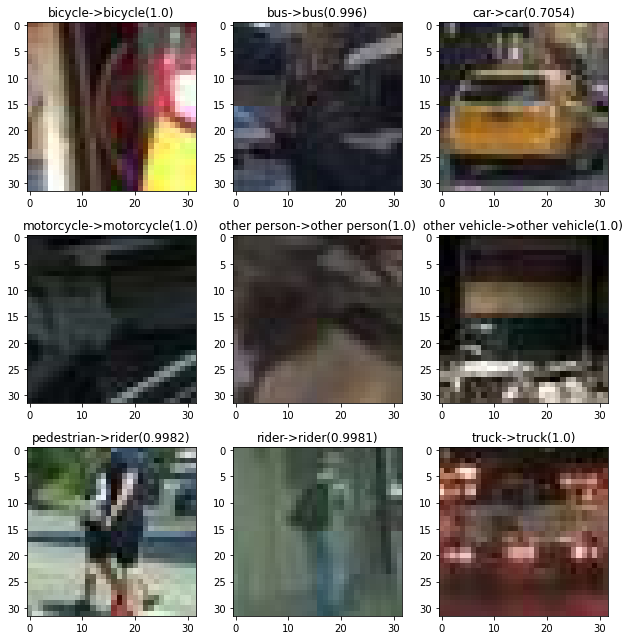

In [67]:
fig = plt.figure(figsize=(9,9))

for idx, image in enumerate(ex_images):
    fig.add_subplot(3,3,idx+1)
    plt.axis=('off')
    plt.imshow(image.astype('float32')/255.0)
    plt.title(f'{class_names[idx]}->{class_names[top1_class[idx]]}'+'({})'.format(str(top1_prediction[idx])))
    plt.tight_layout()


In [68]:
class_names

['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

# positive example

In [175]:

manual_index+=1

manual_index

51

In [206]:
manual_index=481

bicycle prediction....(0)
bus prediction....(1)
car prediction....(2)
motorcycle prediction....(3)
other person prediction....(4)
other vehicle prediction....(5)
pedestrian prediction....(6)
rider prediction....(7)
truck prediction....(8)


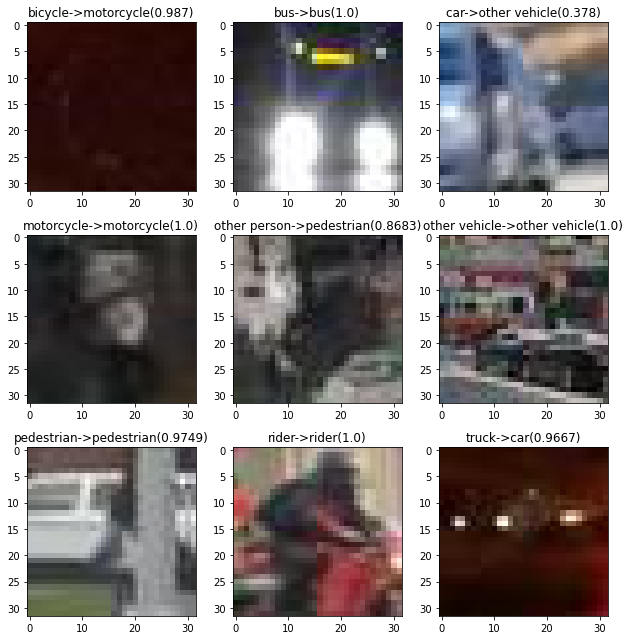

In [207]:
ex_images=[]

for class_name in class_names:
    print(class_name, 'prediction....' f'({class_names.index(class_name)})')
    ex_image_file=os.listdir(os.path.join(test_dir, class_name))[manual_index]
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))

    ex_images.append(ex_image)


ex_images_scaled=np.array(ex_images)

ex_images_scaled=scaling_x(ex_images_scaled, x_train_mean)


prediction=model.predict(ex_images_scaled)

top1_class=prediction.argmax(1)

top1_prediction=[]

for i, class_idx in enumerate(top1_class):
    top1_prediction.append(np.round(prediction[i][class_idx], 4))

fig = plt.figure(figsize=(9,9))

for idx, image in enumerate(ex_images):
    fig.add_subplot(3,3,idx+1)
    plt.axis=('off')
    plt.imshow(image.astype('float32')/255.0)
    plt.title(f'{class_names[idx]}->{class_names[top1_class[idx]]}'+'({})'.format(str(top1_prediction[idx])))
    plt.tight_layout()


In [208]:
# 이 때 그냥 무작정 잘 맞춘 경우  
positive_ulti=[30, 27, 27, 31, 33, 28, 28, 29, 33]

# 이 때 positive는 정확도 높게 맞췄다는 것이 아닌, top1 <-> top2가 비등한 경우이다.
positive_best=[38, 77, 5, 22, 459, 1, 26, 37, 101]

# 이 때 negative 역시 너무 차이나서는 안 된다. top1 <-> top2가 비등한 경우이다.
negative_best=[13, 40, 18, 44, 481, 17, 13, 39, 27]

In [55]:
manual_index=5

In [203]:

target_index=[1,4,8]
for index in range(450,500):
    ex_images=[]
    for idx, class_name in enumerate(class_names):
        if idx not in target_index: # 2,5,9만 딴다.
            continue 
        #print(class_name, 'prediction....' f'({class_names.index(class_name)})')
        ex_image_file=os.listdir(os.path.join(test_dir, class_name))[index]
        ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))

        ex_images.append(ex_image)
        
    ex_images_scaled=np.array(ex_images)
    ex_images_scaled=scaling_x(ex_images_scaled, x_train_mean)
    prediction=model.predict(ex_images_scaled)
    top1_class=prediction.argmax(1)
    top1_prediction=[]
    for i, class_idx in enumerate(top1_class):
        top1_prediction.append(np.round(prediction[i][class_idx], 4))
    print(index, top1_class, top1_prediction)


450 [7 4 8] [0.9851, 1.0, 0.9998]
451 [1 4 1] [1.0, 0.9955, 0.9675]
452 [1 4 8] [0.9998, 0.9833, 0.9998]
453 [1 4 2] [1.0, 0.9951, 0.8283]
454 [1 4 0] [0.8723, 1.0, 0.9948]
455 [1 4 8] [1.0, 1.0, 0.9951]
456 [1 4 2] [0.9994, 1.0, 0.9998]
457 [1 4 8] [1.0, 1.0, 1.0]
458 [1 4 8] [0.9999, 1.0, 0.8857]
459 [1 4 8] [1.0, 0.82, 0.6633]
460 [1 4 2] [1.0, 1.0, 0.9162]
461 [1 4 8] [1.0, 1.0, 0.6899]
462 [1 4 8] [1.0, 0.9796, 0.9998]
463 [1 2 8] [0.9458, 0.9923, 1.0]
464 [1 4 8] [0.9995, 1.0, 0.9808]
465 [1 4 8] [0.9718, 1.0, 0.993]
466 [1 4 8] [0.7238, 0.9999, 0.9999]
467 [1 4 8] [1.0, 0.9993, 1.0]
468 [1 4 8] [1.0, 1.0, 0.9992]
469 [1 4 2] [0.9994, 1.0, 0.8125]
470 [1 4 8] [1.0, 1.0, 0.9999]
471 [1 4 8] [1.0, 1.0, 1.0]
472 [1 4 8] [0.6047, 1.0, 0.9999]
473 [1 4 8] [1.0, 1.0, 1.0]
474 [5 4 8] [0.5264, 1.0, 1.0]
475 [1 4 8] [1.0, 1.0, 0.9983]
476 [1 4 3] [0.9812, 1.0, 0.5705]
477 [1 4 8] [0.9999, 1.0, 1.0]
478 [1 4 7] [1.0, 1.0, 0.9956]
479 [1 4 2] [0.9998, 1.0, 0.9127]
480 [1 4 8] [0.9999, 1.0,

오류..

In [147]:
ex_image=ex_image.reshape(1, 32, 32, 3)

In [36]:
model(ex_image)

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=array([[0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>

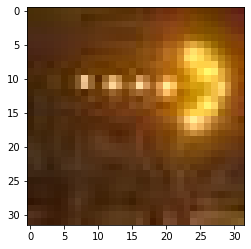

In [38]:
plt.imshow(ex_image[0])

> LIME은 데이터 하나와 데이터에 대한 분류 확률을 출력하는 모델을 파라미터로 받는다.  
이 외에 서브모듈러 분할 알고리즘을 선정할 수 있다.

In [214]:
# model_regressor를 수정해 설명 모델을 바꿀 수 있고
# segmentation_fn 파라미터를 수정해 이미지분할 알고리즘을 사용할 수 있다.
# 슈퍼픽셀 : 디지털 이미지를 구성하는 점들 중 같은 정보를 가진 점의 집합을 의미한다.

from lime import lime_image # 이미지 모듈
from lime.wrappers.scikit_image import SegmentationAlgorithm # liem이 사용할 수 있게. 

explainer=lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘 : quickshift(default), slic, felzenswalb


### hyper : n_segments, compactness, sigma, + Algorithm

In [319]:
index=6

In [210]:
# 이 때 그냥 무작정 잘 맞춘 경우  
positive_ulti=[30, 27, 27, 31, 33, 28, 28, 29, 33]

# 이 때 positive는 정확도 높게 맞췄다는 것이 아닌, top1 <-> top2가 비등한 경우이다.
positive_best=[38, 77, 5, 22, 459, 1, 26, 37, 101]

# 이 때 negative 역시 너무 차이나서는 안 된다. top1 <-> top2가 비등한 경우이다.
negative_best=[13, 40, 18, 44, 481, 17, 13, 39, 27]

In [256]:
train_ds, test_ds=get_dataset()

Found 90000 files belonging to 9 classes.
Found 27000 files belonging to 9 classes.


In [258]:
def _get_dataset():
    
    
    """Returns (ds_train, ds_test) with augmentations on training set.
    """
    T = torchvision.transforms
        
    ds_train = torchvision.datasets.ImageFolder(root, 
            transform=T.ToTensor())
    ds_test = torchvision.datasets.ImageFolder(root_test, 
            transform=T.ToTensor())
    
    return ds_train, ds_test

In [229]:
from skimage.color import label2rgb # 

### Best

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bicycle


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bus


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


motorcycle


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


other person


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


other vehicle


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pedestrian


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rider


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


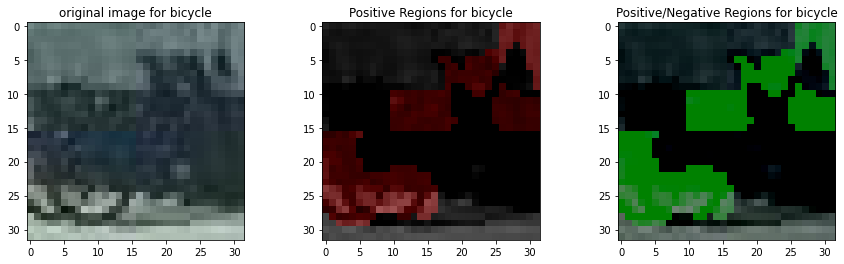

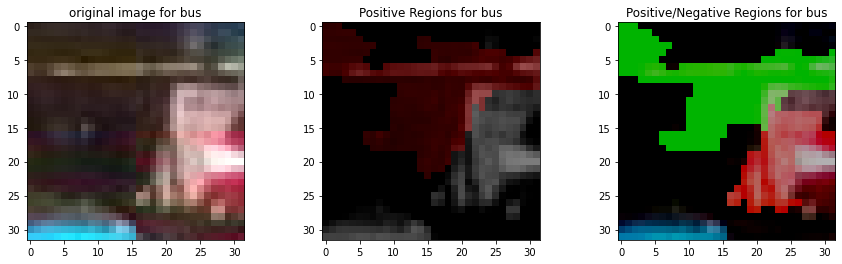

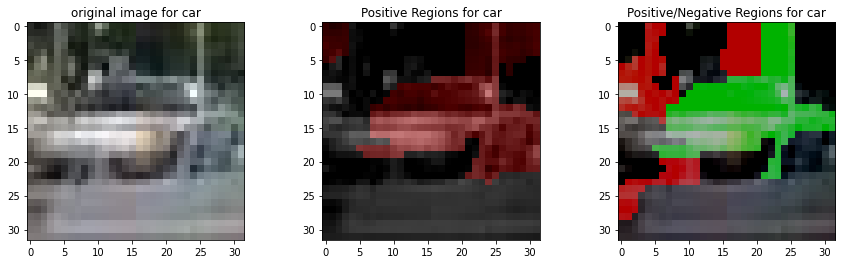

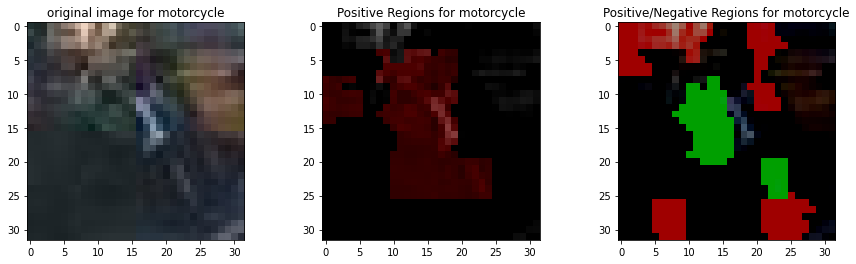

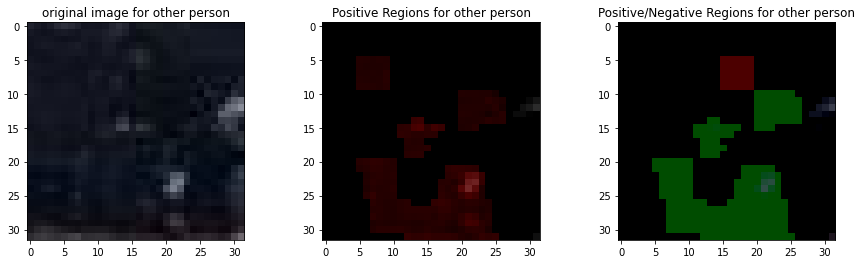

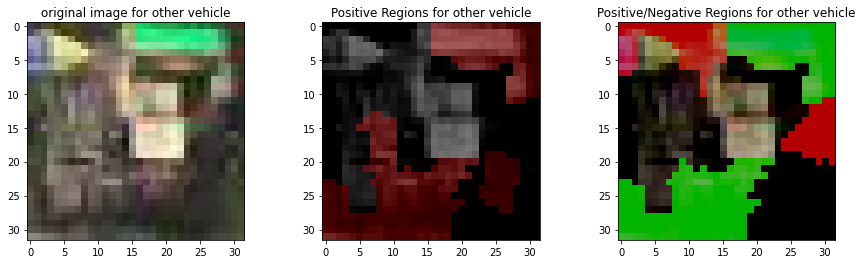

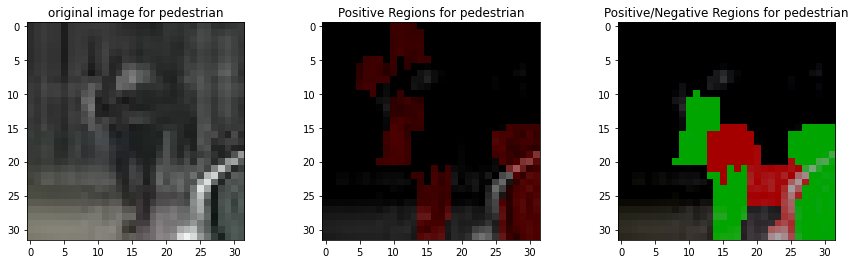

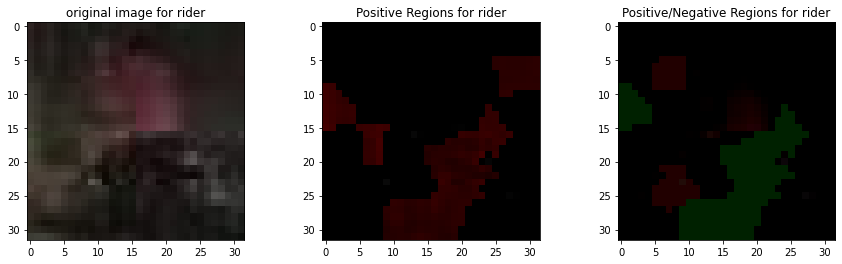

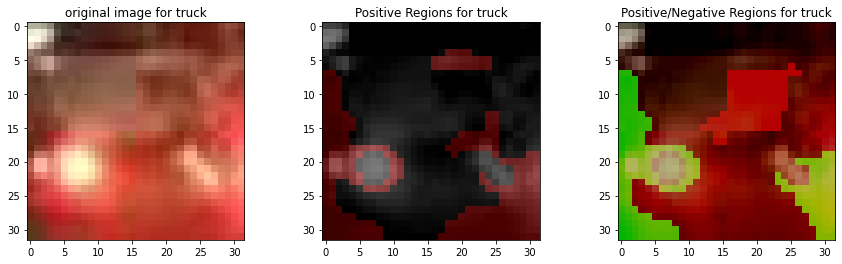

In [244]:
for idx, class_name in enumerate(class_names):    
    compact=5
    segments=50
    sigma=0.5
    
    sample_idx=positive_ulti[idx]
    segmenter=SegmentationAlgorithm('slic', 
                                   n_segments=segments, #이미지 분할 조각 개수
                                   compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                                   sigma=sigma) # 스무딩 역할, 0과 1 사이의 float
    
    explainer=lime_image.LimeImageExplainer()
    ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
    ex_image_scaled=scaling_x(ex_image, x_train_mean)
    
    exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                                  classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                                  top_labels=5, # 확률 기준 1-5위 분석
                                   num_samples=1000,# 샘플링 공간
                                  segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

    
    

    # 캔버스
    fig, (ax0, ax1, ax2)=plt.subplots(1,3,figsize=(15,4))
    ax=[ax0, ax1,ax2]s
    for i in ax:
        i.grid(False)
    # 예측에 가장 도움되는 세그먼트만 출력
    print(class_names[idx])
    temp, mask=exp.get_image_and_mask(idx,
                                     positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                     num_features=8, # 분할 영역의 크기
                                     hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
    ax0.imshow(ex_image)
    ax0.set_title('original image for {}'.format(class_names[idx]))
    # label2rgb : 형광색 마스킹
    ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
    ax1.set_title('Positive Regions for {}'.format(class_names[idx]))

    # 모든 세그먼트 출력
    temp, mask=exp.get_image_and_mask(idx,
                                     positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                     num_features=8, # 분할 영역의 크기
                                     hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
    ax2.imshow(temp, interpolation='nearest')
#     ax2.set_title('Show output image only')
#     ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
    ax2.set_title('Positive/Negative Regions for {}'.format(class_names[idx]))



In [218]:
y_test_num=np.argmax(y_test, axis=-1)

>> 역시 스케일링 한 상태여야 한다.

## Top1 positive, negative

In [223]:
class_names

['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

### Top3 positive

In [247]:
ex_image_scaled.shape

(32, 32, 3)

In [278]:
y_pred[0]

array([7.7466428e-01, 4.6655140e-04, 2.9179394e-06, 4.3836728e-02,
       4.7607422e-02, 3.5550445e-02, 8.8547602e-02, 9.3239350e-03,
       2.3086000e-07], dtype=float32)

### Class 별 Best 찾기

In [ ]:
# for idx, class_name in enumerate(class_names):

class_name=
compact=5
segments=50
sigma=0.5

sample_idx=positive_best[idx]
segmenter=SegmentationAlgorithm('slic', 
                               n_segments=segments, #이미지 분할 조각 개수
                               compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                               sigma=sigma) # 스무딩 역할, 0과 1 사이의 float

explainer=lime_image.LimeImageExplainer()
ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
ex_image_scaled=scaling_x(ex_image, x_train_mean)
y_pred=model.predict(ex_image_scaled.reshape(-1, 32, 32, 3))
exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=3, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘


fig,m_axs=plt.subplots(2,3, figsize=(12,6))


first=1
for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):

    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    print(i)
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(class_names[i],
                                                           100*y_pred[0][i]))
    c_ax.axis('off')


    ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_ulti[i]]
    ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
    if first==1:
        ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_best[i]]
        ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
    gt_ax.imshow(ref_image)


    gt_ax.set_title('Example of {}'.format(class_names[i]))
    gt_ax.axis('off')



/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
6
4


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
8
2


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
5
1


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
3
6


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
3
0


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
8
1


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
7
3


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
6
3


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
1
5


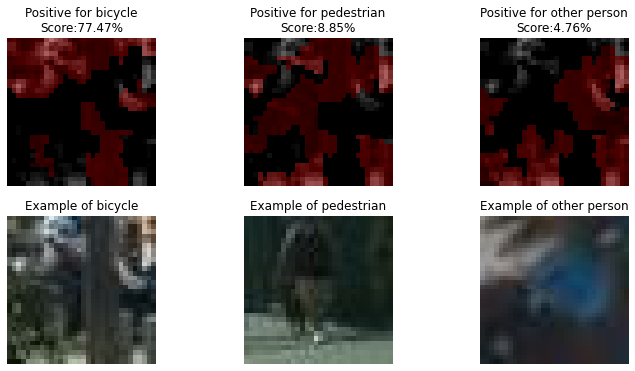

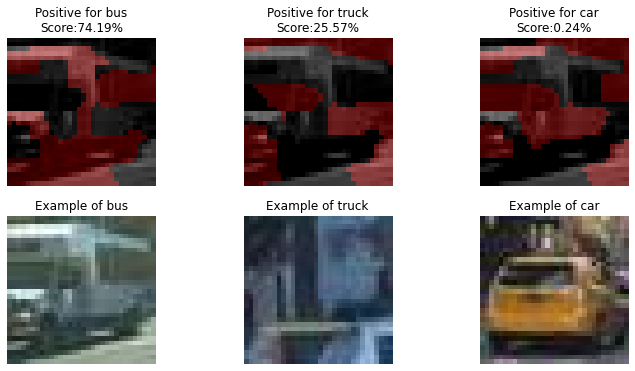

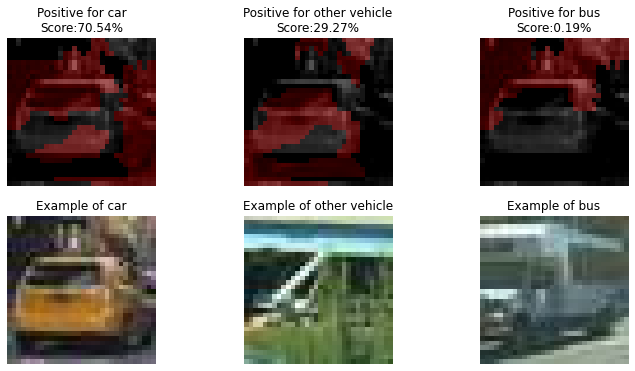

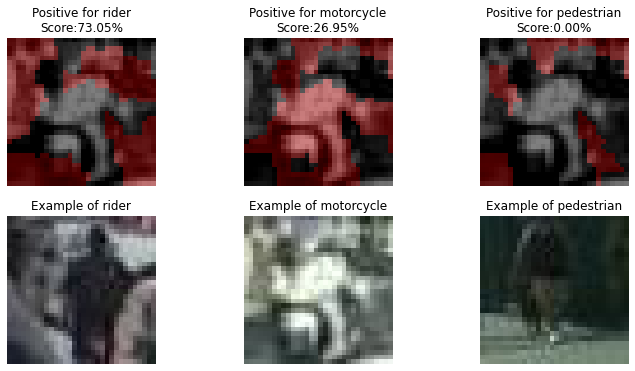

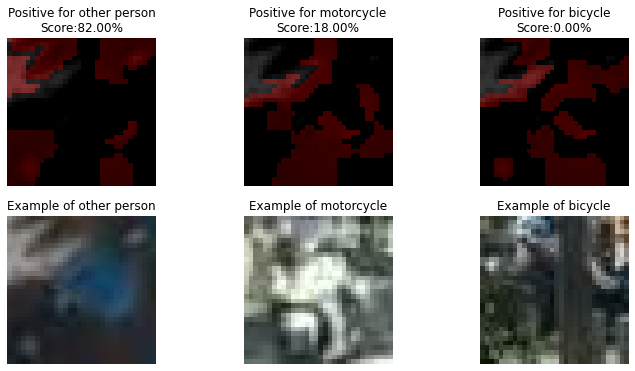

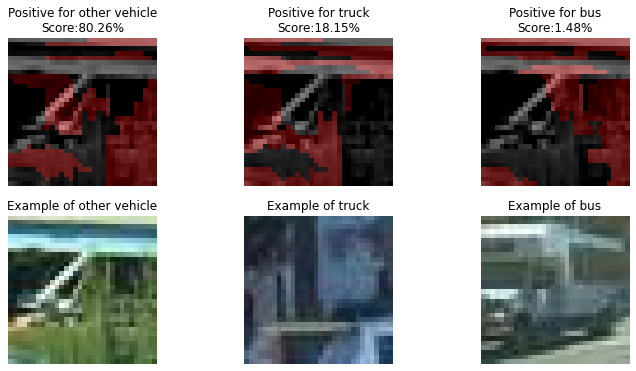

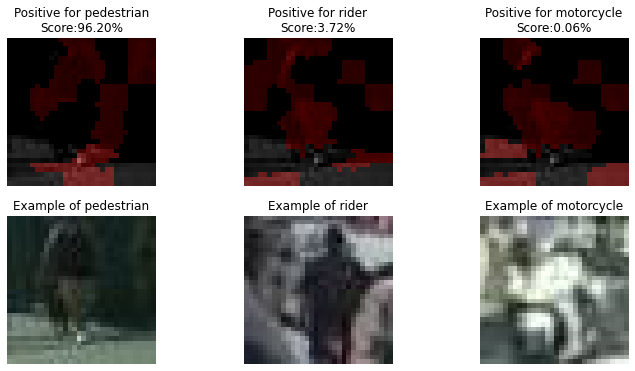

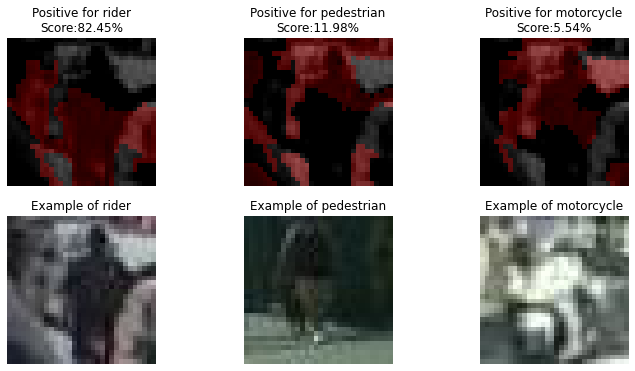

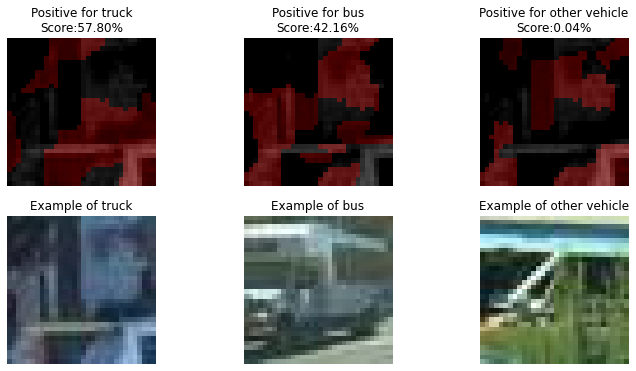

In [283]:
for idx, class_name in enumerate(class_names):
   
    compact=5
    segments=50
    sigma=0.5
    
    sample_idx=positive_best[idx]
    segmenter=SegmentationAlgorithm('slic', 
                                   n_segments=segments, #이미지 분할 조각 개수
                                   compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                                   sigma=sigma) # 스무딩 역할, 0과 1 사이의 float
    
    explainer=lime_image.LimeImageExplainer()
    ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
    ex_image_scaled=scaling_x(ex_image, x_train_mean)
    y_pred=model.predict(ex_image_scaled.reshape(-1, 32, 32, 3))
    exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                                  classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                                  top_labels=3, # 확률 기준 1-5위 분석
                                   num_samples=1000,# 샘플링 공간
                                  segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

    
    fig,m_axs=plt.subplots(2,3, figsize=(12,6))

    
    first=1
    for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
        
        temp, mask=exp.get_image_and_mask(i,
                                             positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                             num_features=12, # 분할 영역의 크기
                                             hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                             min_weight=0.001) 
        c_ax.imshow(label2rgb(mask, temp, bg_label=0),
                   interpolation='nearest')
        print(i)
        c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(class_names[i],
                                                               100*y_pred[0][i]))
        c_ax.axis('off')
        
        
        ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_ulti[i]]
        ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
        if first==1:
            ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_best[i]]
            ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
        gt_ax.imshow(ref_image)
        
        
        gt_ax.set_title('Example of {}'.format(class_names[i]))
        gt_ax.axis('off')



In [272]:
y_pred

array([[8.5973581e-03, 4.6746248e-08, 1.8007449e-07, 9.8695427e-01,
        2.1951477e-12, 1.1685114e-06, 4.1183175e-06, 4.4391956e-03,
        3.5472976e-06],
       [1.0739545e-07, 9.9999726e-01, 4.9225285e-10, 1.8637732e-12,
        1.0333861e-13, 1.2826844e-09, 1.1350691e-10, 5.8704579e-08,
        2.4589431e-06],
       [1.0401256e-02, 3.6984542e-01, 3.0228676e-04, 5.7475899e-07,
        1.5088992e-02, 3.7797725e-01, 1.8299107e-03, 2.3038636e-05,
        2.2453126e-01],
       [2.5006299e-13, 2.4772130e-16, 7.9685390e-13, 9.9999964e-01,
        3.9799994e-13, 9.9789619e-16, 2.5579530e-10, 4.1594367e-07,
        1.5162726e-16],
       [5.6636296e-09, 1.0005268e-10, 8.9203802e-08, 1.8027475e-02,
        8.0970688e-07, 1.1357743e-01, 8.6834753e-01, 4.6610414e-05,
        7.9816708e-08],
       [5.1477461e-08, 5.6433290e-08, 3.1380736e-13, 9.2977427e-13,
        1.1413526e-14, 9.9999988e-01, 1.0919411e-12, 8.8140724e-15,
        1.5485387e-10],
       [6.6242791e-03, 2.6871549e-09, 4.

In [265]:
'Positive for {}\nScore:{:2.2f}%'.format(class_names[i],100*y_pred[i])

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [267]:
100*y_pred[0]

array([8.5973579e-01, 4.6746250e-06, 1.8007449e-05, 9.8695427e+01,
       2.1951477e-10, 1.1685114e-04, 4.1183174e-04, 4.4391957e-01,
       3.5472977e-04], dtype=float32)

In [ ]:
y_pre

In [607]:
exp=explainer.explain_instance(X_test[0], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘


/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
y_pred=model.predict(X_test)
y_pred_num=np.argmax(y_pred, axis=1)
print(classification_report(y_true=y_test_num, y_pred=y_pred_num))

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

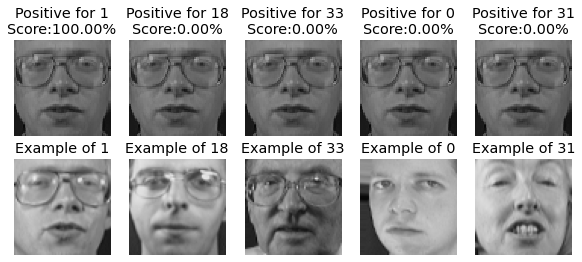

In [640]:
%matplotlib inline
## 조금 더 자세히 출력하자. (기존의 )
test_idx=74
exp=explainer.explain_instance(X_test[test_idx], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

fig,m_axs=plt.subplots(2,2, figsize=(4,4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*y_pred[test_idx, i]))
    c_ax.axis('off')
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

## 백업

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Show mask only')

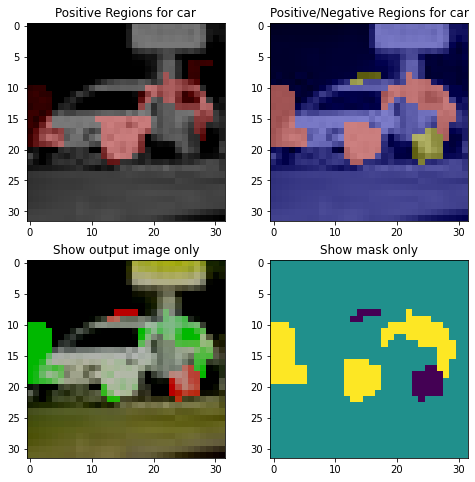

In [324]:
from skimage.color import label2rgb # 

# 캔버스
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(y_test_num[index],
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(class_names[y_test_num[index]]))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(y_test_num[index],
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(class_names[y_test_num[index]]))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형


In [ ]:
from skimage.color import label2rgb # 

# 캔버스
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(y_test_num[olivetti_test_index],
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(y_test_num[olivetti_test_index]))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(y_test_num[olivetti_test_index],
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(y_test_num[olivetti_test_index]))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형


Text(0.5, 1.0, 'Show mask only')

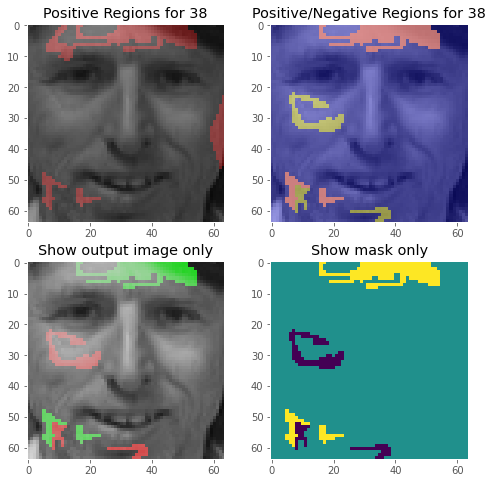

In [537]:
from skimage.color import label2rgb # 

# 캔버스
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(y_test_num[15],
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(y_test_num[15]))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(y_test_num[15],
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(y_test_num[15]))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형


### 해석하기

In [659]:
# 캔버스
def show_lime(index):
    fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
    ax=[ax1,ax2,ax3,ax4]
    for idx, i in enumerate(ax):
        
        exp=explainer.explain_instance(X_train[index[idx]], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

        # 예측에 가장 도움되는 세그먼트만 출력
        temp, mask=exp.get_image_and_mask(y_train_num[index[idx]],
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=8, # 분할 영역의 크기
                                         hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
        # label2rgb : 형광색 마스킹
        i.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
        i.set_title('Positive Regions for {}'.format(y_train_num[index[idx]]))
        i.grid(False)


> 틀린 sample : 16, 11, 14, 6, 28, 3, 

In [637]:
y_test_num

array([ 7, 35, 21, 34, 18,  7, 26, 11, 18,  4, 20, 38,  6,  1, 16, 38, 23,
       36, 11, 16, 22,  3,  9, 37, 14, 12, 38,  6,  9, 22, 10,  5,  8, 22,
       39, 37, 39, 28,  2,  7, 16, 30, 20,  3,  0, 32, 17,  8, 24,  1, 11,
       27, 28, 36, 11,  8, 14, 27, 25, 16, 26, 12, 15,  0, 24, 12, 21,  5,
       26, 19, 36, 38, 36, 28,  1, 27, 31, 39,  2,  1])

In [646]:
from sklearn.metrics import classification_report
y_pred=model.predict(X_test)
y_pred_num=np.argmax(y_pred, axis=1)
print(classification_report(y_true=y_test_num, y_pred=y_pred_num))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       0.67      1.00      0.80         2
          10       1.00      1.00      1.00         1
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         3
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         1
          16       1.00      0.75      0.86         4
          17       1.00      1.00      1.00         1
          18       1.00    

> 잘 분류한 1,38을 대상으로 살펴보자.

In [627]:
np.where(y_test_num==35)[0]

array([1])

In [605]:
person1=np.where(y_test_num==1)[0][2:]
person38=np.where(y_test_num==38)[0][2:]

list_people=list(person1)+list(person38)

list_people

[74, 79, 26, 71]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

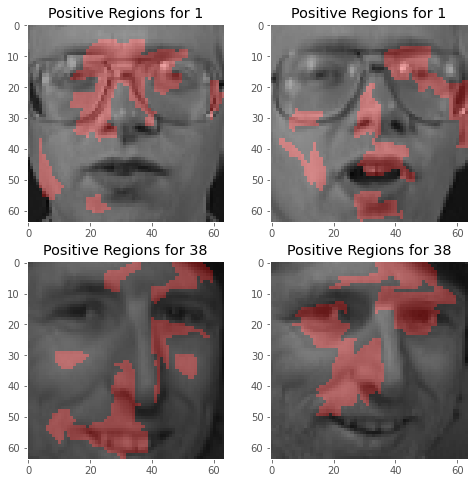

In [606]:
show_lime(list_people)

> 자세히 출력

In [607]:
exp=explainer.explain_instance(X_test[0], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘


/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

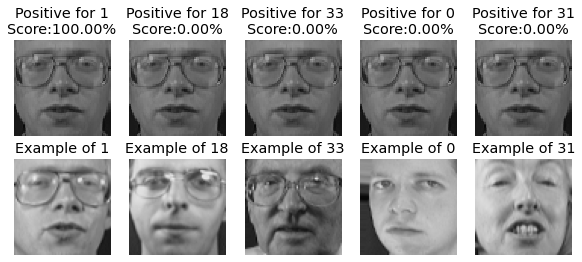

In [640]:
%matplotlib inline
## 조금 더 자세히 출력하자. (기존의 )
test_idx=74
exp=explainer.explain_instance(X_test[test_idx], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

fig,m_axs=plt.subplots(2,5, figsize=(10,4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*y_pred[test_idx, i]))
    c_ax.axis('off')
    
    face_id=np.random.choice(np.where(y_train_num==i)[0])
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

> (잘 못 판별한)3을 대상으로 살펴보자. (28이후)

In [641]:
np.where(y_test_num==3)

(array([21, 43]),)

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

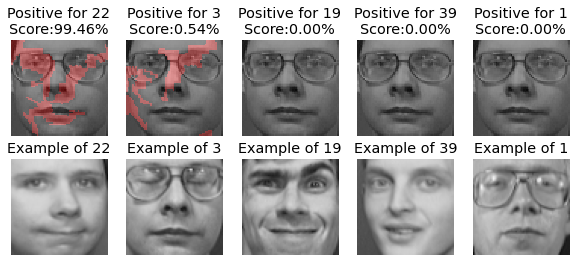

In [643]:
%matplotlib inline
## 조금 더 자세히 출력하자. (기존의 )
test_idx=43
exp=explainer.explain_instance(X_test[test_idx], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

fig,m_axs=plt.subplots(2,5, figsize=(10,4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*y_pred[test_idx, i]))
    c_ax.axis('off')
    
    face_id=np.random.choice(np.where(y_train_num==i)[0])
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

In [644]:
np.where(y_test_num==28)

(array([37, 52, 73]),)

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

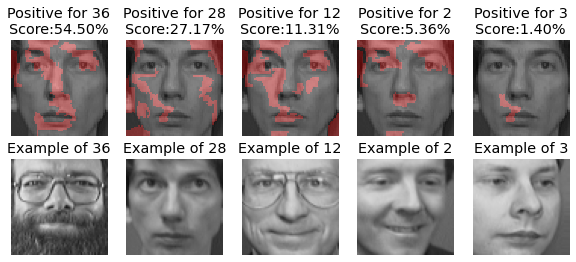

In [645]:
%matplotlib inline
## 조금 더 자세히 출력하자. (기존의 )
test_idx=37
exp=explainer.explain_instance(X_test[test_idx], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

fig,m_axs=plt.subplots(2,5, figsize=(10,4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*y_pred[test_idx, i]))
    c_ax.axis('off')
    
    face_id=np.random.choice(np.where(y_train_num==i)[0])
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

In [654]:
np.where(y_train_num==36)

(array([  7,  31,  51,  53, 265, 286]),)

In [647]:
np.where(y_test_num==36)

(array([17, 53, 70, 72]),)

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

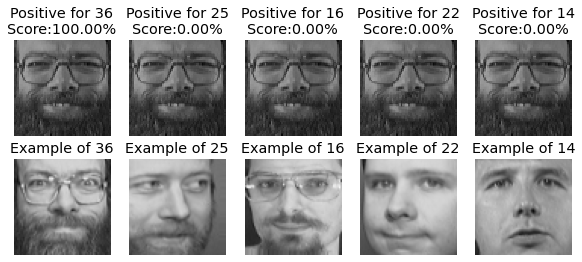

In [650]:
%matplotlib inline
## 조금 더 자세히 출력하자. (기존의 )
test_idx=70
exp=explainer.explain_instance(X_test[test_idx], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

fig,m_axs=plt.subplots(2,5, figsize=(10,4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*y_pred[test_idx, i]))
    c_ax.axis('off')
    
    face_id=np.random.choice(np.where(y_train_num==i)[0])
    
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

In [658]:
np.where(y_train_num==36)[0][:4]

array([ 7, 31, 51, 53])

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mskang/.conda/envs/jinsu/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

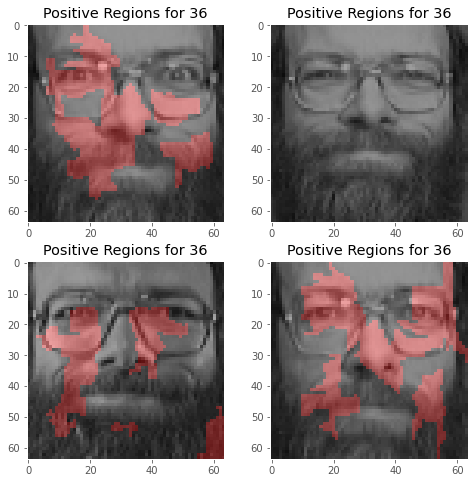

In [661]:
show_lime(np.where(y_train_num==36)[0][2:])

# 기타 함수

In [12]:
def get_dataset():
    train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
    test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

    batch_size = 128
    img_height = 32
    img_width = 32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    return train_ds, test_ds

In [13]:
def batch_to_numpy(train_ds, test_ds):

    # av dataset
    # 0610 : 9개의 클래스에 대해 train(!0000), test(3000)
    x_train_base=np.zeros([90000, 32, 32, 3])
    y_train_base=np.zeros([90000, 1])
    x_test_base=np.zeros([27000, 32, 32, 3])
    y_test_base=np.zeros([27000, 1])

    numpy_iter=list(train_ds.as_numpy_iterator())

    for idx, batch in enumerate(numpy_iter):
    #     if idx%30==0:
    #         print(idx)
        x_train_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_train_base[128*idx:128*(idx+1), 0]=batch[1]

    numpy_iter_test=list(test_ds.as_numpy_iterator())

    len(numpy_iter_test)

    for idx, batch in enumerate(numpy_iter_test):
    #     if idx%30==0:
    #         print(idx)
        x_test_base[128*idx:128*(idx+1), :, :, :]=batch[0]
        y_test_base[128*idx:128*(idx+1), 0]=batch[1]
    
    return x_train_base, y_train_base, x_test_base, y_test_base